# Train and Tune all Models for Comparison

In [1]:
from pathlib import Path

import pandas as pd

from config.config import Config
from src.models.factory import Experiment
from src.models.linreg import LinearElasticNet
from src.plots import plot_forecast_diagnostics, plot_forecast_next_h, plot_test_overlay_h1, prep_h1_overlay, \
    prep_h_overlay
from src.runners import run_experiments
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
SEED = cfg.runtime.seed
HORIZON = cfg.runtime.horizon
rng = set_seed(SEED)

2025-08-24 17:02:08,156 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / "features_full.csv")

In [4]:
experiments = [
    Experiment(
        name="linreg",
        build=lambda horizon, seed: LinearElasticNet(horizon=HORIZON, random_state=SEED, multioutput=True),
        include_sentiment=True
    ),
    Experiment(
        name="linreg_wo_sent",
        build=lambda horizon, seed: LinearElasticNet(horizon=HORIZON, random_state=SEED, multioutput=True),
        include_sentiment=False
    ),
    # Experiment(
    #     name="xgboost",
    #     build=lambda horizon, seed: XGBoost(random_state=seed),
    #     include_sentiment=True
    # )
]

In [5]:
results = run_experiments(df_full, Path(cfg.data.processed_dir), experiments, HORIZON, SEED)

2025-08-24 17:02:08,321 - INFO - ModelTrainer - Initialized ModelTrainer for model: linreg
[I 2025-08-24 17:02:08,322] A new study created in memory with name: no-name-6902372c-3b9a-4f58-af7d-356f6dad0296
2025-08-24 17:02:08,322 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+00, tolerance: 3.910e-02
  model = cd_fast.enet_coordinate_descent(
[I 2025-08-24 17:02:08,601] Trial 0 finished with value: 0.010132885964950848 and parameters: {'alpha': 0.0001329291894316216, 'l1_ratio': 0.9507143064099162, 'max_iter': 3500, 'selection': 'cyclic'}. Best is trial 0 with value: 0.010132885964950848.
2025-08-24 17:02:08,602 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\sit

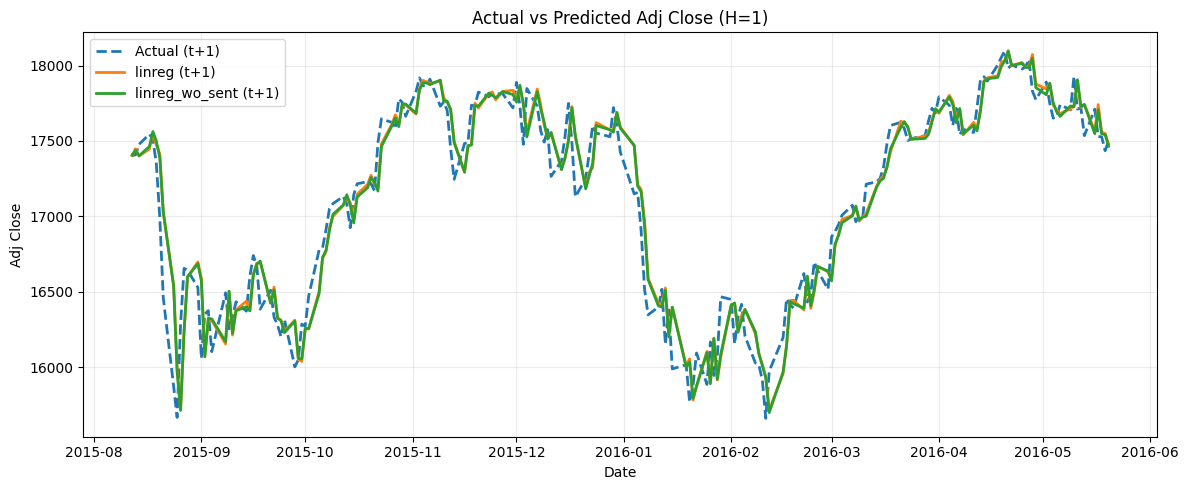

In [6]:
dates_next, actual_next, pred_next_by_model = prep_h1_overlay(df_full, results)
plot_test_overlay_h1(
    dates_next=dates_next,
    actual_next=actual_next,
    pred_next_by_model=pred_next_by_model,
    path=Path(cfg.data.fig_dir) / "all_actual_vs_predicted_adj_close.png",
)

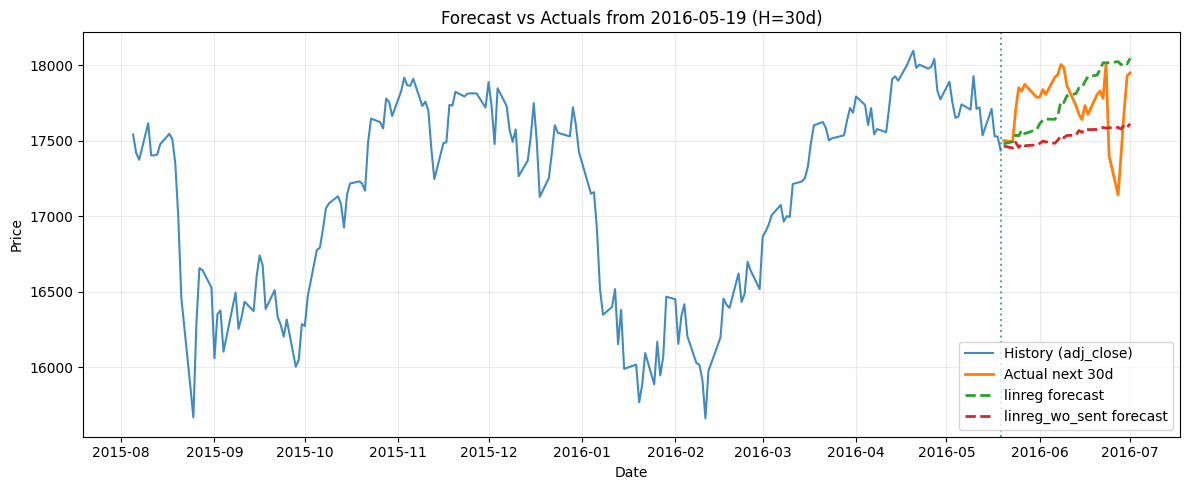

In [7]:
hist_dates, hist_prices, fut_dates, actual_path, anchor_date, paths_by_model = prep_h_overlay(df_full, results, HORIZON)
plot_forecast_next_h(
    hist_dates=hist_dates,
    hist_prices=hist_prices,
    fut_dates=fut_dates,
    forecast_paths_by_model=paths_by_model,
    actual_path=actual_path,
    anchor_date=anchor_date,
    H=HORIZON,
    path=Path(cfg.data.fig_dir) / "all_forecast.png",
)

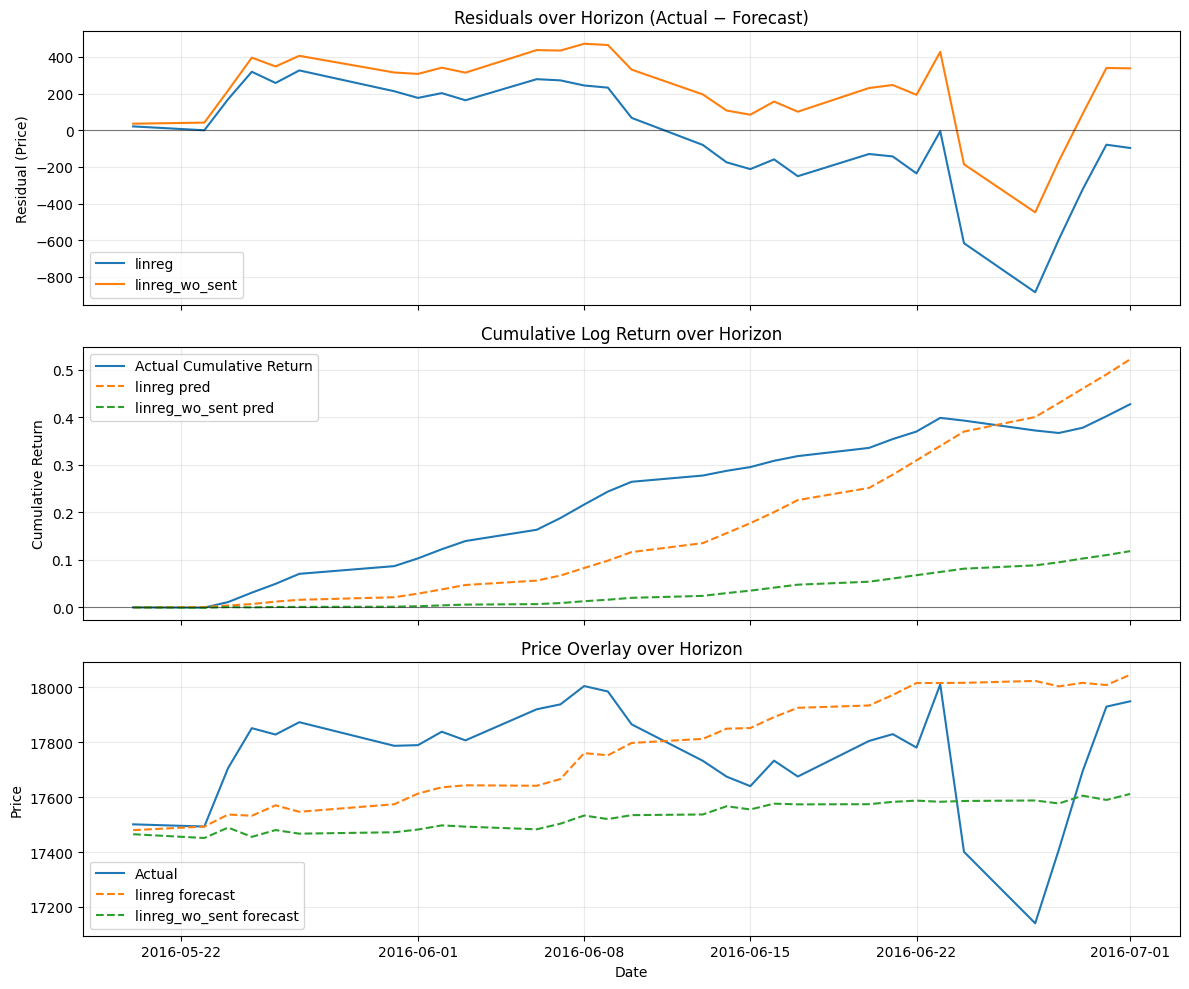

In [8]:
plot_forecast_diagnostics(
    fut_dates=fut_dates,
    actual_path=actual_path,
    forecast_paths_by_model=paths_by_model,
    path=Path(cfg.data.fig_dir) / "all_forecast_diagnostics.png",
)